# Connect to your workspace

In [2]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.44.0 to work with nahmed30-azureml-workspace


# Create Compute

In [3]:
# Create compute

from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.core.compute_target import ComputeTargetException

# NOTE: update the cluster name to match the existing cluster
# Choose a name for your CPU cluster
amlcompute_cluster_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',# for GPU, use "STANDARD_NC6"
                                                           #vm_priority = 'lowpriority', # optional
                                                           max_nodes=4)
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True, min_node_count = 1, timeout_in_minutes = 10)
# For a more detailed view of current AmlCompute status, use get_status().


Found existing cluster, use it.
Succeeded.......................................................................................................
AmlCompute wait for completion finished

Wait timeout has been reached
Current provisioning state of AmlCompute is "Succeeded" and current node count is "0"


# Prepare data

In [4]:
from azureml.core import Dataset

found = False
key = "UdacityPrjEmailSpamDataSet"
description_text = "Spam Detection DataSet for Udacity Capstone Proj "

emailspam_ds = None
if key in ws.datasets.keys(): 
        found = True
        emailspam_ds = ws.datasets[key] 
if found:
        emailspam_ds
        df = emailspam_ds.to_pandas_dataframe()

df.describe()

,v1,v2,Column3,Column4,Column5
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""",GE,"GNT:-)"""
freq,4825,30,3,2,2


# Prepare a training script

In [13]:
import os

experiment_folder = 'smsspam_hyperdrive_experiment_v1'
os.makedirs(experiment_folder, exist_ok=True)

print('Folder ready.')

train_script_name='smsspam_training_v09132022_1.py'
train_env_yml='smsspam_hyperdrive_env_v09132022_1.yml'
experiment_name='smsspam-hyperdrive-exp-v09122022-1'


Folder ready.


# Create  Python script to train the model.

In [58]:
%%writefile $experiment_folder/smsspam_training_v09132022_1.py

# Import libraries
import argparse, joblib, os
from azureml.core import Run

import logging
import os
import csv
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn import datasets
import tensorflow as tf
import regex as re
from tensorflow import keras
from tensorflow.keras import layers

import pickle
import tempfile
from tensorflow.keras.models import Sequential, load_model, save_model, Model
from tensorflow.keras.layers import Dense


from sklearn.preprocessing import StandardScaler
# from tensorflow.keras import models, layers

import nltk
from nltk.corpus import stopwords
from sklearn.metrics import roc_auc_score, roc_curve

import azureml.core
from azureml.core import Workspace
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace

from azureml.core.dataset import Dataset


# Get the experiment run context
run = Run.get_context()

# Get script arguments
parser = argparse.ArgumentParser()

# Input dataset
parser.add_argument("--input-data", type=str, dest='input_data', help='training dataset')

#hyperdrive_feature
parser.add_argument("--hyperdrive_feature", type=bool, dest='hyperdrive_feature', help='hyperdrive feature')

# Hyperparameters
parser.add_argument('--units', type=int, default=64, help="Number of nodes")
parser.add_argument('--optimizer', type=str, default='adam', help="Algorithm of Choice")

# Add arguments to args collection
args = parser.parse_args()

# Log Hyperparameter values 
run.log("Number of Nodes:", np.int(args.units))  
run.log("Algorithm of Choice:", np.str(args.optimizer))  

# load the email spam dataset -- Get the training data from the input
print("Loading Email Spam Data...")
df = run.input_datasets['training_data'].to_pandas_dataframe() 

# Cleanup and Prepare Data # Find and eliminate stop words 
nltk.download('stopwords')
stop_words= set(stopwords.words("english"))
stop_words.update(['https', 'http', 'amp', 'CO', 't', 'u', 'new', "I'm", "would"])


spam = df.query("v1=='spam'").v2.str.cat(sep=" ")
ham = df.query("v1=='ham'").v2.str.cat(sep=" ")

# convert spam to 1 and ham to 0
df = df.replace('spam', 1)
df = df.replace('ham', 0)

# Clean the text
def clean_text(text):
    whitespace = re.compile(r"\s+")
    web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = text.replace('.', '')
    text = whitespace.sub(' ', text)
    text = web_address.sub('', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    return text.lower()

df.v2 = [clean_text(item) for item in df.v2]

# Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.oov_token = '<oovToken>'
tokenizer.fit_on_texts(df.v2)
vocab = tokenizer.word_index
vocabCount = len(vocab)+1


# Split Train and Test
SPLIT = 5000

# Split data into training set and test set
xTrain = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(df.v2.to_numpy()), padding='pre', maxlen=171)
yTrain = df.v1.to_numpy()

dim = xTrain.shape[1]
xTest = xTrain[SPLIT:]
yTest = yTrain[SPLIT:]

xTrain = xTrain[:SPLIT]
yTrain = yTrain[:SPLIT]

# Train a Keras Sequential classification model without the specified hyperparameters
print('Training a classification model')

#------------------------------------------------------------
#model = tf.keras.Sequential()
#model.add(tf.keras.layers.Embedding(input_dim=vocabCount+1, output_dim=64, input_length=dim))
#model.add(tf.keras.layers.GlobalAveragePooling1D())
#model.add(tf.keras.layers.Dense(64, activation='relu'))
#model.add(tf.keras.layers.Dense(32, activation='relu'))
#model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.summary()

#--------------------------------------------------------------

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocabCount+1, output_dim=64, input_length=dim))
model.add(tf.keras.layers.GlobalAveragePooling1D())
# for i in range(args.num_layers):
model.add(tf.keras.layers.Dense(args.units, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.compile(loss='binary_crossentropy', optimizer=args.optimizer, metrics=['accuracy'])
model.summary()


history = model.fit(xTrain, yTrain, batch_size=32, epochs=30, initial_epoch=6, validation_data=(xTest, yTest))

# calculate accuracy
# y_hat = model.predict(xTest)
# acc = np.average(y_hat == yTest)
# print('Accuracy:', acc)
# run.log('Accuracy', np.float64(acc))

print('history type: ', type(history))

eval_result = model.evaluate(xTest, yTest)

print('evaluated results: ', eval_result)

run.log('Loss', np.float64(eval_result[0]))
run.log('Accuracy', np.float64(eval_result[1]))

accuracy_pct = np.float64(eval_result[1])

print('Model Accuracy:  %.2f' % (accuracy_pct * 100))

# calculate AUC
# y_scores = model.predict_proba(xTest)
# auc = roc_auc_score(yTest,y_scores[:,1])
# print('AUC: ' + str(auc))
# run.log('AUC', np.float(auc))

#for x in ['acc','val_acc']:
    #run.log('Accuracy', hist.history[x[0]])
#    print (hist.history[x])
#    print (hist.history[x[0]])
#    plt.plot(hist.history[x])

# Create the outputs folder - save any outputs you want managed by AzureML here
os.makedirs('./outputs', exist_ok=True)

print('Saving model history...')
with open(f'outputs/model.history', 'wb') as f:
        pickle.dump(history.history, f)

print('Saving model...')
model.save(f'outputs/')

model.save(f'outputs/sms_spam_check_model_v1.h5')

print('Model is saved Done!')
print('-'*100)


# Save the model in the run outputs
#os.makedirs('outputs', exist_ok=True)
#joblib.dump(value=model, filename='outputs/emailspam_model09122022.pkl')
    

run.complete()


Overwriting smsspam_hyperdrive_experiment_v1/smsspam_training_v09132022_1.py


You'll need a Python environment to be hosted on the compute, so let's define that as Conda configuration file.

In [53]:
%%writefile $experiment_folder/smsspam_hyperdrive_env_v09132022_1.yml
name: batch_environment
dependencies:
- python=3.8.5
- scikit-learn
- pandas
- numpy
- regex
- tensorflow
- nltk
- pip
- pip:
  - azureml-defaults

Overwriting smsspam_hyperdrive_experiment_v1/smsspam_hyperdrive_env_v09132022_1.yml


# Run a hyperparameter tuning experiment

In [59]:
from azureml.core import Experiment, ScriptRunConfig, Environment
from azureml.train.hyperdrive import RandomParameterSampling, HyperDriveConfig, PrimaryMetricGoal, choice
from azureml.widgets import RunDetails

# Create a Python environment for the experiment
hyper_env = Environment.from_conda_specification("experiment_env", experiment_folder + "/" +train_env_yml)


hyperdrive_feature = True

# Create a script config
script_config = ScriptRunConfig(source_directory=experiment_folder,
                                script=train_script_name,
                                # Add non-hyperparameter arguments -in this case, the training dataset
                                arguments = ['--input-data', emailspam_ds.as_named_input('training_data'),
                                '--hyperdrive_feature', hyperdrive_feature],
                                environment=hyper_env,
                                compute_target = amlcompute_cluster_name)

                                
# ----------------------------------------------------------------------

params = RandomParameterSampling( 
    {
    "--units": choice(80),
    "--optimizer": choice('adam')
    })

# Configure hyperdrive settings
hyperdrive = HyperDriveConfig(run_config=script_config, 
                          hyperparameter_sampling=params, 
                          policy=None, # No early stopping policy
                          primary_metric_name='Accuracy', # Find the highest Accuracy metric
                          primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                          max_total_runs=24, # Restict the experiment to 48 iterations
                          max_concurrent_runs=2) # Run up to 2 iterations in parallel

# Run the experiment
experiment = Experiment(workspace=ws, name=experiment_name)
run = experiment.submit(config=hyperdrive)

# Show the status in the notebook as the experiment runs

# RunDetails(run).show()
run.wait_for_completion()


{'runId': 'HD_cba4c1da-9839-4248-918e-810e73b7e452',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2022-09-14T03:47:48.904986Z',
 'endTimeUtc': '2022-09-14T03:49:52.069834Z',
 'services': {},
 'properties': {'primary_metric_config': '{"name":"Accuracy","goal":"maximize"}',
  'resume_from': 'null',
  'runTemplate': 'HyperDrive',
  'azureml.runsource': 'hyperdrive',
  'platform': 'AML',
  'ContentSnapshotId': '9b877abe-e877-4e6a-adf6-aa613dfdbc73',
  'user_agent': 'python/3.8.12 (macOS-10.15.7-x86_64-i386-64bit) msrest/0.6.21 Hyperdrive.Service/1.0.0 Hyperdrive.SDK/core.1.44.0',
  'space_size': '1',
  'score': '0.9860140085220337',
  'best_child_run_id': 'HD_cba4c1da-9839-4248-918e-810e73b7e452_0',
  'best_metric_status': 'Succeeded',
  'best_data_container_id': 'dcid.HD_cba4c1da-9839-4248-918e-810e73b7e452_0'},
 'inputDatasets': [],
 'outputDatasets': [],
 'runDefinition': {'configuration': None,
  'attribution': None,
  'telemetryValues': {'amlClientType': 'azurem

# Determine the best performing run

In [60]:
# Print all child runs, sorted by the primary metric
for child_run in run.get_children_sorted_by_primary_metric():
    print(child_run)

{'run_id': 'HD_cba4c1da-9839-4248-918e-810e73b7e452_0', 'hyperparameters': '{"--optimizer": "adam", "--units": 80}', 'best_primary_metric': 0.9860140085220337, 'status': 'Completed'}


In [61]:
# Get the best run, and its metrics and arguments
best_run = run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()

In [62]:
script_arguments = best_run.get_details() ['runDefinition']['arguments']
print('Best Run Id: ', best_run.id)

Best Run Id:  HD_cba4c1da-9839-4248-918e-810e73b7e452_0


In [75]:
print(' -Accuracy:', best_run_metrics['Accuracy'])
print(' -Arguments:',script_arguments)

 -Accuracy: 0.9860140085220337
 -Arguments: ['--input-data', 'DatasetConsumptionConfig:training_data', '--hyperdrive_feature', 'True', '--optimizer', 'adam', '--units', '80']


Now that you've found the best run, you can register the model it trained.

In [64]:
# Download the files.
best_run.download_files(output_directory='smsspam_model_output_v2')

In [71]:
import tensorflow.keras as K

# load the model
model = K.models.load_model(f'smsspam_model_output_v2/outputs/sms_spam_check_model_v1.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 171, 64)           550848    
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 80)                5200      
                                                                 
 dense_1 (Dense)             (None, 32)                2592      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 558,673
Trainable params: 558,673
Non-trainable params: 0
__________________________________________________

In [72]:
model.name

'sequential'

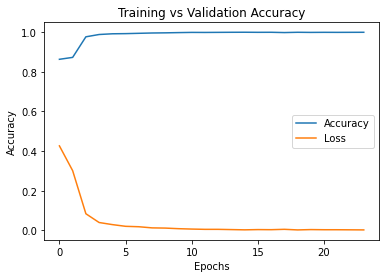

In [69]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# load model history
with open(f'smsspam_model_output_v2/outputs/model.history', 'rb') as fp:
    history = pickle.load(fp)
    
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['loss'], label='Loss')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [70]:
MODEL_DIR = "smsspam_model_output_v2/outputs" 
export_path = os.path.join(MODEL_DIR) 
print(export_path)

smsspam_model_output_v2/outputs


In [77]:
model.save(export_path, save_format="tf") 
print('\nexport_path = {}'.format(export_path))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('signature_function', 'signature_key'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: smsspam_model_output_v2/outputs/assets

export_path = smsspam_model_output_v2/outputs


In [79]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['embedding_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 171)
        name: serving_default_embedding_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Defined Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          inputs: T

In [73]:
from azureml.core import Model

# Register model
# outputs/emailspam_model09122022.pkl
reg_model = best_run.register_model(model_path='outputs/sms_spam_check_model_v1.h5', model_name='sequential',
                        tags={'Training context':'Hyperdrive'},
                        properties={'Accuracy': best_run_metrics['Accuracy']})

In [81]:
reg_model

Model(workspace=Workspace.create(name='nahmed30-azureml-workspace', subscription_id='16bc73b5-82be-47f2-b5ab-f2373344794c', resource_group='epe-poc-nazeer'), name=sequential, id=sequential:2, version=2, tags={'Training context': 'Hyperdrive'}, properties={'Accuracy': '0.9860140085220337'})

In [90]:
type(model)

keras.engine.sequential.Sequential

In [82]:
from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType
from inference_schema.parameter_types.pandas_parameter_type import PandasParameterType
from inference_schema.parameter_types.standard_py_parameter_type import StandardPythonParameterType

In [84]:
import pandas as pd
import numpy as np

input_sample = pd.DataFrame({"v2": pd.Series(["Who are you"], dtype="object"), "Column4": pd.Series(["example_value"], dtype="object"), "Column5": pd.Series(["example_value"], dtype="object"), "Column6": pd.Series(["example_value"], dtype="object")})
output_sample = np.array(["example_value"])
method_sample = StandardPythonParameterType("predict")

In [85]:
input_schema('method', method_sample, convert_to_provided_type=False)
input_schema('data', PandasParameterType(input_sample))
output_schema(NumpyParameterType(output_sample))

<function inference_schema.schema_decorators.output_schema.<locals>.decorator_input(user_run, instance, args, kwargs)>

In [86]:
data =  {
  "data": [
    {
      "v2": "example_value",
      "Column4": "example_value",
      "Column5": "example_value",
      "Column6": "example_value"
    }
  ],
  "method": "predict"
}

In [92]:
type(data)

dict

In [95]:
data.get('data')[0].get('v2')

'example_value'

In [110]:
input_sample.get('v2')

0    Who are you
Name: v2, dtype: object

In [109]:
input_sample.get('v2').values

array(['Who are you'], dtype=object)

In [113]:
input_sample.get('v2')[0]

'Who are you'

In [ ]:
result = model.predict(input_sample.get('v2')[0])

In [116]:
model

In [ ]:
text = "You won $100 click link below to collect"
processedText = clean_text(text)
#print(processedText)
finalText = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([processedText]), padding='pre', maxlen=171)
print(finalText)

In [ ]:
result = model.predict("This is a test")

In [ ]:


result = model.predict(data)

In [ ]:
result = model.predict("This is a test")

In [96]:
import re

def clean_text(text):
    whitespace = re.compile(r"\s+")
    web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = text.replace('.', '')
    text = whitespace.sub(' ', text)
    text = web_address.sub('', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    return text.lower()

In [99]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.oov_token = '<oovToken>'
tokenizer.fit_on_texts("You won $100 ")
vocab = tokenizer.word_index
vocabCount = len(vocab)+1

vocabCount

16

In [102]:
import tensorflow as tf

text = "You won $100 click link below to collect"
processedText = clean_text(text)
#print(processedText)
finalText = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([processedText]), padding='pre', maxlen=171)
prediction = model.predict(finalText)
print("prediction shape", prediction.shape)
print(prediction)
print(np.int(np.rint(prediction[0,0])))

1/1 [==============================] - 0s 36ms/step
prediction shape (1, 1)
[[0.05449035]]
0


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
result = reg_model.predict(data)

In [37]:
from azureml.core.model import InferenceConfig

# Combine scoring script & environment in Inference configuration
inference_config = InferenceConfig(entry_script="09102022/score.py",
                                   environment=hyper_env)

In [38]:
from azureml.core.webservice.aci import AciWebservice
# Set deployment configuration
deployment_config = AciWebservice.deploy_configuration(cpu_cores = 1,
                                                       memory_gb = 1)

In [39]:
# Define the model, inference, & deployment configuration and web service name and location to deploy
service = Model.deploy(workspace = ws,
                       name = "my-smsspam-service-v1",
                       models = [reg_model],
                       inference_config = inference_config,
                       deployment_config = deployment_config)

service.wait_for_deployment(show_output=True)

In [40]:
service

AciWebservice(workspace=Workspace.create(name='nahmed30-azureml-workspace', subscription_id='16bc73b5-82be-47f2-b5ab-f2373344794c', resource_group='epe-poc-nazeer'), name=my-smsspam-service-v1, image_id=None, image_digest=None, compute_type=ACI, state=Transitioning, scoring_uri=None, tags={}, properties={'azureml.git.repository_uri': 'https://github.com/Nazeer2013/nd00333-capstone.git', 'mlflow.source.git.repoURL': 'https://github.com/Nazeer2013/nd00333-capstone.git', 'azureml.git.branch': 'master', 'mlflow.source.git.branch': 'master', 'azureml.git.commit': '5a0671ea693258335dd7d3d443969a0cb0e8c232', 'mlflow.source.git.commit': '5a0671ea693258335dd7d3d443969a0cb0e8c232', 'azureml.git.dirty': 'True'}, created_by={'userObjectId': 'a8930881-263c-498d-8975-58e6a0c28f2c', 'userPuId': '10032001567EC76C', 'userIdp': None, 'userAltSecId': None, 'userIss': 'https://sts.windows.net/db05faca-c82a-4b9d-b9c5-0f64b6755421/', 'userTenantId': 'db05faca-c82a-4b9d-b9c5-0f64b6755421', 'userName': 'Nazee